In [0]:
! pip install -q stellargraph[demos]

In [0]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline

### загружаем датасет CORA

In [0]:
dataset = sg.datasets.Cora()
G, node_subjects = dataset.load()

### разбиваем на обучающю. тестовую и валидационную выборки

In [0]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=200, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

### преобразуем текстовые названия меток в бинарные вектора

In [0]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

### создаем GCN слои

In [37]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [0]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [0]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [40]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<tf.Tensor 'graph_convolution_3/Identity:0' shape=(1, None, 16) dtype=float32>

In [0]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Обучаем модель

In [0]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [0]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [0]:
history = model.fit(
    train_gen,
    epochs=800,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

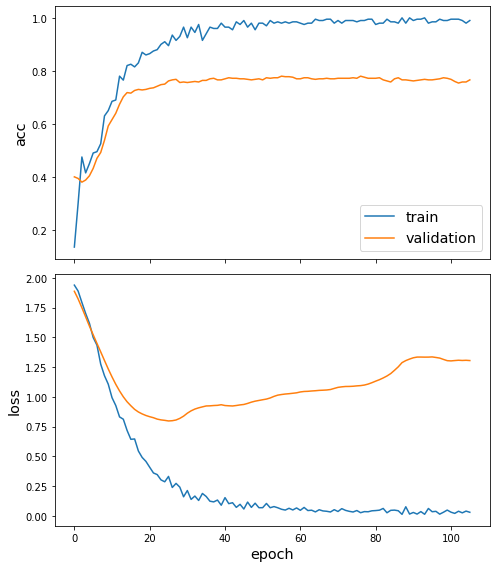

In [46]:
sg.utils.plot_history(history)

In [0]:
test_gen = generator.flow(test_subjects.index, test_targets)

### Получаем прогноз модели и сравниваем c истинным значением

In [0]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [0]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [67]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(15)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


### Делаем визуализацию
##### Каждой вершине сопоставляем вектор, понижаем размерность, отображаем на плоскости, красим точки  в соответствии с их истинной меткой в один из 7 цветов. Если модель прогнозирует хорошо, то мы получим более или менее одноцветные кластеры.

In [0]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [54]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [56]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [57]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

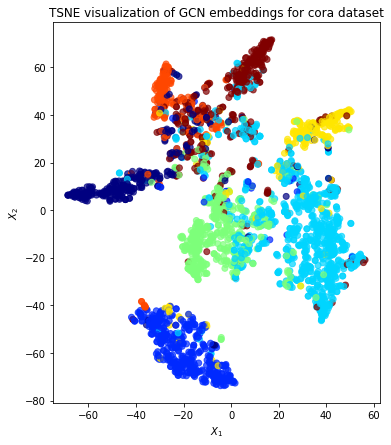

In [58]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/gcn/gcn-cora-node-classification-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/gcn/gcn-cora-node-classification-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>